# Data Processing + Table Building

**Imports & Connection**

In [6]:
import pymysql
import csv
import pprint
import re
from pathlib import Path
# from langdetect import detect
import langid

### Establishing MySQL Server Connection

In [7]:
db_name = 'test'

In [8]:
# Open the connection to the database 
conn = pymysql.connect(host="localhost",           
                             user="root",             
                             passwd="",   
                             db=db_name,
                             autocommit=True,
                             cursorclass=pymysql.cursors.DictCursor)

**Processing CorrectedMetadata.csv** (building language and language_names tables)

In [14]:
# BUILDING the languages TABLE

with connection.cursor() as cursor:
    
    # empty caption table so that we can run this from a known state.
    full_query = "TRUNCATE languages;"
    cursor.execute(full_query)
    
    full_query1 = "TRUNCATE language_names;"
    cursor.execute(full_query1)
    
    # correctedMetadata.csv data format/columns: Wikipedia.Language.Code,Language.name..English.,Language.name..native.,Last.Updated
    with open('data/correctedMetadata.csv') as csvfile:
        myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
        
        # languages_names table select statement
        language_id_sql = """SELECT id FROM languages WHERE std_english_name = %(Language.name..English.)s"""
        
        
        for row in myCSVReader:
            # building languages table
            language_sql = """INSERT INTO languages(std_english_name) VALUE (%(Language.name..English.)s)"""
            cursor.execute(language_sql, row)
            
            # building languages_names table
            cursor.execute(language_id_sql, row)
            result = cursor.fetchone()
            language_id = result['id']

            language_name1_sql = """INSERT INTO language_names(name,language_id) VALUE
                            (%(name)s, %(language_id)s)"""

            param_dict1 = { "name": row["Wikipedia.Language.Code"],
                       "language_id": language_id }
            
            cursor.execute(language_name1_sql, param_dict1)
            
            language_name2_sql = """INSERT INTO language_names(name,language_id) VALUE
                            (%(name)s, %(language_id)s)"""

            param_dict2 = { "name": row["Language.name..English."],
                       "language_id": language_id }
            
            cursor.execute(language_name2_sql, param_dict2)

**Processing our 81 language sentiment lexicon csvs** (building sentiments & words_in_language tables)

In [18]:
with connection.cursor() as cursor:

    # empty sentiments table so that we can run this from a known state.
    full_query = "TRUNCATE sentiments;"
    cursor.execute(full_query)

    # build sentiment table manually
    pos_sentiment_sql = """INSERT INTO sentiments(type,score) 
                                    VALUE ("positive","1")"""
    cursor.execute(pos_sentiment_sql)
    
    neg_sentiment_sql = """INSERT INTO sentiments(type,score) 
                                    VALUE ("negative","-1")"""
    cursor.execute(neg_sentiment_sql)
 
    hate_sentiment_sql = """INSERT INTO sentiments(type,score) 
                                    VALUE ("hate","-2")"""
    cursor.execute(hate_sentiment_sql)
    
    # empty words_in_language table so that we can run this from a known state.
    full_query1 = "TRUNCATE words_in_language;"
    cursor.execute(full_query1)
    
    filenamelist = Path('data/sentiment').glob('*.txt')
    
    # loop through a list of filenames in our directory of sentiment lexicons
    #(\D+)\_words\_(\D+)\.txt columns: word - inserted manually below
    for filename in Path('data/sentiment').glob('*.txt'):
        
        # pprint.pprint(filename)
        # open each filename as a csv file
        with open(filename) as csvfile:
            # pprint.pprint(filename) # just to check all files were getting read
            
            # search each filename in directory for the words in it corresponding to sentiment and language 
            matches = re.search('csv\/sentiment\/(\D+)\_words\_(\D+)\.txt',str(filename))
            # the first group is the sentiment
            sentiment = matches.group(1)
            # pprint.pprint(sentiment) # used just to check correct sentiment identification
            # the second group is the language (abbreviated in 2-3 letter ISO 639-2 Code)
            language = matches.group(2)
            # pprint.pprint(language) # used just to check correct language identification
            
            # reads the csv file as if it has a header (word) which it doesn't
            headers = ["word"]
            myCSVReader = csv.DictReader(csvfile,fieldnames=headers)
            
            # loops through rows in the sentiment lexicon at hand
            for row in myCSVReader:
                
                # create a row with the language from the file name
                row["language"] = language
                # find the language_id 
                language_name_id_sql = """SELECT language_id FROM language_names WHERE name = %(language)s"""
                cursor.execute(language_name_id_sql, row)
                result = cursor.fetchone()
                language_id = result['language_id']

                # create a row with the sentiment from the file name
                row["sentiment"] = sentiment
                # find the sentiment_id 
                sentiment_id_sql = """SELECT id FROM sentiments WHERE type = %(sentiment)s"""
                cursor.execute(sentiment_id_sql, row)
                result = cursor.fetchone()
                sentiment_id = result['id']

                # build words_in_language table with word_id EXCLUDED (word_id will default to NULL)
                words_in_language_sql = """INSERT INTO words_in_language(word,language_id,sentiment_id) 
                                                VALUE (%(word)s, %(language_id)s, %(sentiment_id)s)"""

                param_dict1 = { "word": row["word"],
                            "language_id": language_id,
                            "sentiment_id": sentiment_id }

                cursor.execute(words_in_language_sql, param_dict1)

**Processing our Hate Speech csvs** (adding to *sentiments* and *words_in_language* tables)

In [21]:
with connection.cursor() as cursor:

    # loop through a list of filenames in our directory of sentiment lexicons
    #(\D+)\_speech\_(\D+)\.csv columns: word
    for filename in Path('data/hatespeech').glob('*.csv'):
        
        # open each filename as a csv file
        with open(filename, encoding='utf-8-sig') as csvfile:
            # pprint.pprint(filename) # just to check all files were getting read
            
            # search each filename in directory for the words in it corresponding to sentiment and language 
            matches = re.search('csv\/hatespeech\/(\D+)\_speech\_(\D+)\.csv',str(filename))
            # the first group is the sentiment
            sentiment = matches.group(1)
            # pprint.pprint(sentiment) # used just to check correct sentiment identification
            # the second group is the language (abbreviated in 2-3 letter ISO 639-2 Code)
            language = matches.group(2)
            # pprint.pprint(language) # used just to check correct language identification

            myCSVReader = csv.DictReader(csvfile)
            
            # loops through rows in the sentiment lexicon at hand
            for row in myCSVReader:
                
                # create a row with the language from the file name
                row["language"] = language
                # find the language_id 
                language_name_id_sql = """SELECT language_id FROM language_names WHERE name = %(language)s"""
                cursor.execute(language_name_id_sql, row)
                result = cursor.fetchone()
                language_id = result['language_id']

                # create a row with the sentiment from the file name
                row["sentiment"] = sentiment
                # find the sentiment_id 
                sentiment_id_sql = """SELECT id FROM sentiments WHERE type = %(sentiment)s"""
                cursor.execute(sentiment_id_sql, row)
                result = cursor.fetchone()
                sentiment_id = result['id']
                
                # build words_in_language table with word_id EXCLUDED (word_id will default to NULL)
                words_in_language_sql = """INSERT INTO words_in_language(word,language_id,sentiment_id) 
                                            VALUE (%(word)s,%(language_id)s,%(sentiment_id)s)"""

                param_dict1 = { "word": row["word"],
                            "language_id": language_id,
                            "sentiment_id": sentiment_id }

                cursor.execute(words_in_language_sql, param_dict1)

                

**Processing our Meme Generator dataset** (building to *basememes*, *memes*, *captions*, and *words* tables)

In [26]:
with connection.cursor() as cursor:

# empty base_memes, memes, captions, words tables so that we can run from a known state.
    full_query = "TRUNCATE base_memes;"
    cursor.execute(full_query)
    
    truncate_query_1 = "TRUNCATE memes;"
    cursor.execute(truncate_query_1)
    
    truncate_query_2 = "TRUNCATE captions;"
    cursor.execute(truncate_query_2)
    
    truncate_query_3 = "TRUNCATE words;"
    cursor.execute(truncate_query_3)
    
    # memegenerator.csv columns: Meme ID,Archived URL,Base Meme Name,Meme Page URL,MD5 Hash,File Size (In Bytes),Alternate Text,Display Name,Upper Text,Lower Text
    with open('data/memegenerator.csv') as csvfile:
        myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
        
        # building base_memes table
        sql = "SELECT id FROM base_memes WHERE base_meme = %(Base_Meme_Name)s"
        
        # building meme table
        sql_select_base_meme_id = "SELECT id FROM base_memes WHERE base_meme = %(Base_Meme_Name)s"
        
        for row in myCSVReader:   
            cursor.execute(sql, row)

            if (cursor.rowcount == 1):
                # if an id is returned for this base meme, execute no sql - don't add it
                pass
            else:
                # if no id value is returned for this base meme, add it with this sql
                base_meme_sql = """INSERT INTO base_memes(base_meme) 
                                      VALUE (%(Base_Meme_Name)s)"""
                cursor.execute(base_meme_sql, row)  
            
            # use the Base Meme Name from the row to get the base_meme_id 
            cursor.execute(sql_select_base_meme_id, row)
            result = cursor.fetchone()
            base_meme_id = result['id']
            
            meme_sql = """INSERT INTO memes(base_meme_id,archived_url) VALUE
                            (%(base_meme_id)s,%(archived_url)s)"""
            
            # The memes in our dataset are unnamed, therefore we just insert the id
            param_dict = { "base_meme_id": base_meme_id,
                         "archived_url": row["Meme_Page_URL"]}

            cursor.execute(meme_sql, param_dict)
            
            # CAPTION INPUT
            
            meme_id = cursor.lastrowid # get meme_id for captions
            
            # IDENTIFYING LANGUAGE of both captions using language detection package
            
            # LANGID package 
            detected_language = langid.classify(row["Alternate Text"].lower()) # Alternate Text column is both top and bottom caption together
            param_dict = {'caption_lang': detected_language[0]}
            
            # finding the language_id of the detected language
            caption_language_id_sql = """SELECT language_id FROM language_names WHERE name = %(caption_lang)s"""
            cursor.execute(caption_language_id_sql, param_dict)
            result = cursor.fetchone()
            
            # test to see if the detected language has a lexicon in our database
            if (cursor.rowcount == 1): # if it is, search the appropriate lexicon to look for word matches
            
                lang_test_id = result['language_id']
                # pprint.pprint(lang_test_id)
                # RESULTING VARIABLE is the language_id of the caption's detected language
            
            
                # UPPER CAPTION INPUT
                
                param_dict = {'text_position': "upper",
                              'text': row["Upper Text"],
                              'meme_id': meme_id}
                caption_sql = """INSERT INTO captions(text_position,text,meme_id) 
                                    VALUE (%(text_position)s,%(text)s,%(meme_id)s)"""
                cursor.execute(caption_sql, param_dict)
                caption_id = cursor.lastrowid # get caption_id for captions

                # word prep, upper: remove punctuation, change all words to lower case, and split captions into words
                cleaned_words = re.sub('[\\\$\,\.\?\:\;\!\#\@\%\^\&\*\+]','',row["Upper Text"])
                lower_case_words = cleaned_words.lower()
                wordList = lower_case_words.split(" ")
                # pprint.pprint(wordList) - was used to check that words are getting split into list correctly

                # Loop through all the words in upper caption 
                for word in wordList:

                    # create parameter
                    word_dict = {"word" : word,
                                "lang_test_id" : lang_test_id} 

                    # SQL statement to search for word matches ONLY in the lexicon identifying by the langdetect function
                    word_sql = """SELECT id FROM words_in_language WHERE language_id = %(lang_test_id)s AND word = %(word)s"""
                    cursor.execute(word_sql, word_dict)          

                    # if yes (an id was found) 
                    if (cursor.rowcount == 1):

                        # fetch the result and make it our words_in_language_id
                        result = cursor.fetchone()
                        words_in_language_id = result['id']

                        # build words_in_language table with words_in_language_id included
                        word_sql = """INSERT INTO words(word,caption_id,words_in_language_id) 
                            VALUE (%(word)s,%(caption_id)s,%(words_in_language_id)s)"""
                        param_dict = {'word': word,
                            'caption_id': caption_id,
                            'words_in_language_id': words_in_language_id}

                    else: # an id was NOT found

                        # build words_in_language table with words_in_language_id EXCLUDED (words_in_language_id will default to NULL)
                        word_sql = """INSERT INTO words(word,caption_id) 
                            VALUE (%(word)s,%(caption_id)s)"""
                        param_dict = {'word': word,
                            'caption_id': caption_id}

                    # execute the resulting sql to insert data into words table
                    cursor.execute(word_sql, param_dict)
                
                # LOWER CAPTION INPUT

                param_dict = {'text_position': "lower",
                              'text': row["Lower Text"],
                              'meme_id': meme_id}
                caption_sql = """INSERT INTO captions(text_position,text,meme_id) 
                                    VALUE (%(text_position)s,%(text)s,%(meme_id)s)"""
                cursor.execute(caption_sql, param_dict)
                caption_id = cursor.lastrowid # get caption_id for captions

                # word prep, lower: remove punctuation, change all words to lower case, and split captions into words
                cleaned_words = re.sub('[\\\$\,\.\?\:\;\!\#\@\%\^\&\*\+]','',row["Lower Text"])
                lower_case_words = cleaned_words.lower()
                wordList = lower_case_words.split(" ")
                # pprint.pprint(wordList) - was used to check that words are getting split into list correctly

                # Loop through all the words in lower caption 
                for word in wordList:

                    # create parameter
                    word_dict = {"word" : word,
                                "lang_test_id" : lang_test_id} 

                    # SQL statement to search for word matches ONLY in the lexicon identifying by the langdetect function
                    word_sql = """SELECT id FROM words_in_language WHERE language_id = %(lang_test_id)s AND word = %(word)s"""
                    cursor.execute(word_sql, word_dict)   

                    # if yes (an id was found) 
                    if (cursor.rowcount == 1):

                        # fetch the result and make it our words_in_language_id
                        result = cursor.fetchone()
                        words_in_language_id = result['id']

                        # build words_in_language table with word_id INCLUDED
                        word_sql = """INSERT INTO words(word,caption_id,words_in_language_id) 
                            VALUE (%(word)s,%(caption_id)s,%(words_in_language_id)s)"""
                        param_dict = {'word': word,
                            'caption_id': caption_id,
                            'words_in_language_id': words_in_language_id}


                    else: # an id was NOT found

                        # build words_in_language table with words_in_language_id EXCLUDED (words_in_language_id will default to NULL)
                        word_sql = """INSERT INTO words(word,caption_id) 
                            VALUE (%(word)s,%(caption_id)s)"""
                        param_dict = {'word': word,
                            'caption_id': caption_id}

                    # execute the appropriate sql to insert data into word table
                    cursor.execute(word_sql, param_dict)


            # if detected language not in our database, ingest the words but don't test them against 
            # any of our lexicons
            else: 
                # pprint.pprint(meme_id) 
                # pprint.pprint(row["Alternate Text"])
                # pprint.pprint(detected_language) 
                # were used to see what missing languages were identified and on what memes/captions

                # UPPER CAPTION INPUT

                param_dict = {'text_position': "upper",
                              'text': row["Upper Text"],
                              'meme_id': meme_id}
                caption_sql = """INSERT INTO captions(text_position,text,meme_id) 
                                    VALUE (%(text_position)s,%(text)s,%(meme_id)s)"""
                cursor.execute(caption_sql, param_dict)
                caption_id = cursor.lastrowid # get caption_id for captions

                # word prep, upper: remove punctuation, change all words to lower case, and split captions into words
                cleaned_words = re.sub('[\\\$\,\.\?\:\;\!\#\@\%\^\&\*\+]','',row["Upper Text"])
                lower_case_words = cleaned_words.lower()
                wordList = lower_case_words.split(" ")
                # pprint.pprint(wordList) - was used to check that words are getting split into list correctly

                # Loop through all the words in upper caption 
                for word in wordList:

                    # build words_in_language table with words_in_language_id EXCLUDED 
                    # (words_in_language_id will default to NULL)
                    word_sql = """INSERT INTO words(word,caption_id) 
                        VALUE (%(word)s,%(caption_id)s)"""
                    param_dict = {'word': word,
                        'caption_id': caption_id}

                    cursor.execute(word_sql, param_dict)


                # LOWER CAPTION INPUT

                param_dict = {'text_position': "lower",
                              'text': row["Lower Text"],
                              'meme_id': meme_id}
                caption_sql = """INSERT INTO captions(text_position,text,meme_id) 
                                    VALUE (%(text_position)s,%(text)s,%(meme_id)s)"""
                cursor.execute(caption_sql, param_dict)
                caption_id = cursor.lastrowid # get caption_id for captions

                # word prep, lower: remove punctuation, change all words to lower case, and split captions into words
                cleaned_words = re.sub('[\\\$\,\.\?\:\;\!\#\@\%\^\&\*\+]','',row["Lower Text"])
                lower_case_words = cleaned_words.lower()
                wordList = lower_case_words.split(" ")
                # pprint.pprint(wordList) - was used to check that words are getting split into list correctly

                # Loop through all the words in lower caption 
                for word in wordList:

                    # build words_in_language table with words_in_language_id EXCLUDED 
                    # (words_in_language_id will default to NULL)
                    word_sql = """INSERT INTO words(word,caption_id) 
                        VALUE (%(word)s,%(caption_id)s)"""
                    param_dict = {'word': word,
                        'caption_id': caption_id}

                    # execute the appropriate sql to insert data into word table
                    cursor.execute(word_sql, param_dict)
                    

KeyboardInterrupt: 

**Query to export data for analysis**

In [28]:
# Building our SQL query 

building_query = """
SELECT *
FROM memes

SELECT *
FROM memes
  JOIN base_memes
    ON memes.base_meme_id = base_memes.id
    
SELECT *
FROM memes
  JOIN base_memes
    ON memes.base_meme_id = base_memes.id
  JOIN captions
    ON memes.id = captions.meme_id
  JOIN words
    ON captions.id = words.caption_id
    
SELECT *
FROM memes
  JOIN base_memes
    ON memes.base_meme_id = base_memes.id
  JOIN captions
    ON memes.id = captions.meme_id
  JOIN words
    ON captions.id = words.caption_id
  JOIN words_in_language
    ON words.id = words_in_language.word_id
    
SELECT *
FROM memes
  JOIN base_memes
    ON memes.base_meme_id = base_memes.id
  JOIN captions
    ON memes.id = captions.meme_id
  JOIN words
    ON captions.id = words.caption_id
  JOIN words_in_language
    ON words.id = words_in_language.word_id
  JOIN languages
    ON words_in_language.language_id = languages.id
    
SELECT *
FROM memes
  JOIN base_memes
    ON memes.base_meme_id = base_memes.id
  JOIN captions
    ON memes.id = captions.meme_id
  JOIN words
    ON captions.id = words.caption_id
  JOIN words_in_language
    ON words.id = words_in_language.word_id
  JOIN languages
    ON words_in_language.language_id = languages.id
  JOIN sentiments
    ON words_in_language.sentiment_id = sentiments.id

SELECT memes.id
FROM memes
  JOIN base_memes
    ON memes.base_meme_id = base_memes.id
  JOIN captions
    ON memes.id = captions.meme_id
  JOIN words
    ON captions.id = words.caption_id
  JOIN words_in_language
    ON words.id = words_in_language.word_id
  JOIN languages
    ON words_in_language.language_id = languages.id
  JOIN sentiments
    ON words_in_language.sentiment_id = sentiments.id
ORDER BY memes.id


SELECT memes.id, languages.std_english_name as "language", SUM(sentiments.score) AS sentiment_score
FROM memes
  JOIN base_memes
    ON memes.base_meme_id = base_memes.id
  JOIN captions
    ON memes.id = captions.meme_id
  JOIN words
    ON captions.id = words.caption_id
  JOIN words_in_language
    ON words.words_in_language_id = words_in_language.id
  JOIN languages
    ON words_in_language.language_id = languages.id
  JOIN sentiments
    ON words_in_language.sentiment_id = sentiments.id
GROUP BY memes.id
"""

# Writing our queried results to csv file

with connection.cursor() as cursor:
    
    export_sql = """SELECT memes.id, languages.std_english_name as "language", SUM(sentiments.score) AS sentiment_score
                FROM memes
                  JOIN base_memes
                    ON memes.base_meme_id = base_memes.id
                  JOIN captions
                    ON memes.id = captions.meme_id
                  JOIN words
                    ON captions.id = words.caption_id
                  JOIN words_in_language
                    ON words.words_in_language_id = words_in_language.id
                  JOIN languages
                    ON words_in_language.language_id = languages.id
                  JOIN sentiments
                    ON words_in_language.sentiment_id = sentiments.id
                GROUP BY memes.id"""

    cursor.execute(export_sql)
    # creates a list of dicts out of results of sql query
    export = cursor.fetchall()
    
    # grabs column names from dict keys 
    column_names = export[0].keys()

    # write to the new csv file 
    with open('exported.csv', 'w') as csvfile:

        myCsvWriter = csv.DictWriter(csvfile,
                                     delimiter=',',
                                     quotechar='"',
                                     fieldnames = column_names)

        myCsvWriter.writeheader() # uses contents of column_names

        # write the rows, iterating through the list of dicts
        for row in export:
            myCsvWriter.writerow(row)

    print("Done writing csv.")

Done writing csv.


# Output #

We identified memes in 59 of the 82 of the languages in our lexicons (71.95%). We identified sentiment in 24,601 memes out of 57,687 memes total (42.65%). By far the most common languages of our identified memes were Castillan Spanish (10,430 memes, 42.4%), English (8,376 memes, 34.05%), and Russian (3,678 memes, 14.95%). The next most frequently meme-language was Portuguese at only 1.83% (449 memes). Interestingly the identified Spanish and English memes averaged a slightly negative sentiment score, at -0.47 and -0.176, respectivley, while Russian memes averaged a slighly positive score of 0.46.

Other stats: The average meme in our database was made up of 8.941 words. Kazakh was the most frequently identified language that we did NOT have a lexicon for (but we suspect of those memes may have simply been in Russian). Admittedly, our language detection strategy was not perfect, and we were not able to not account for multi-lingual memes nor for many forms of slang using this model. 


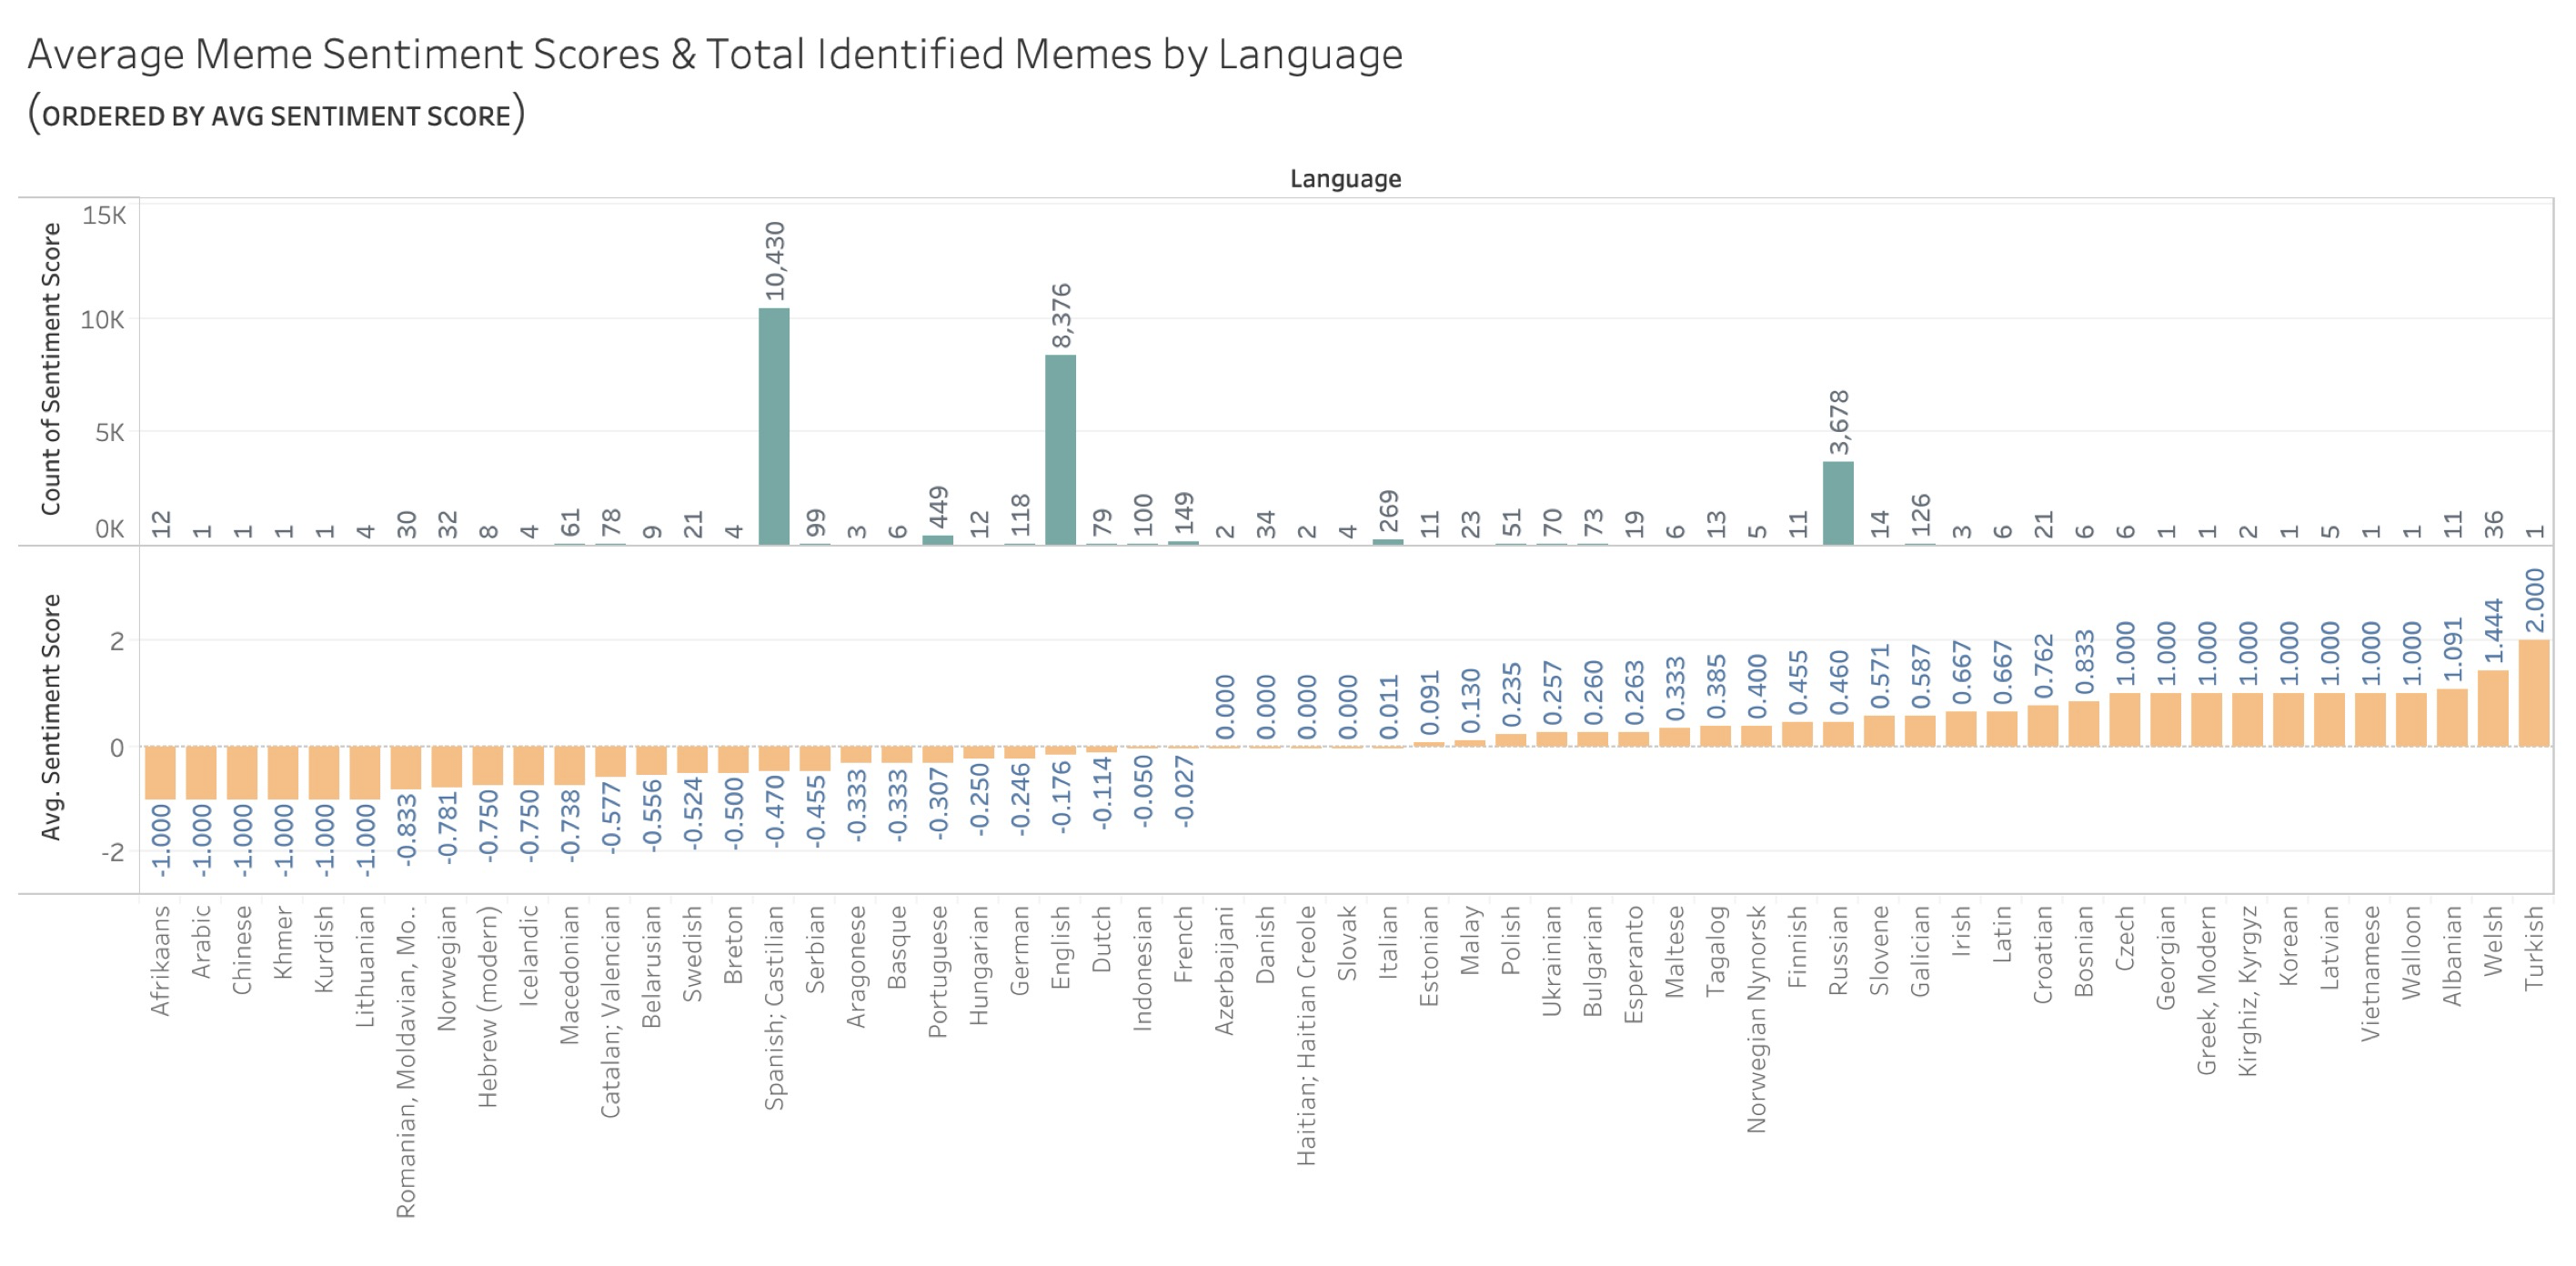

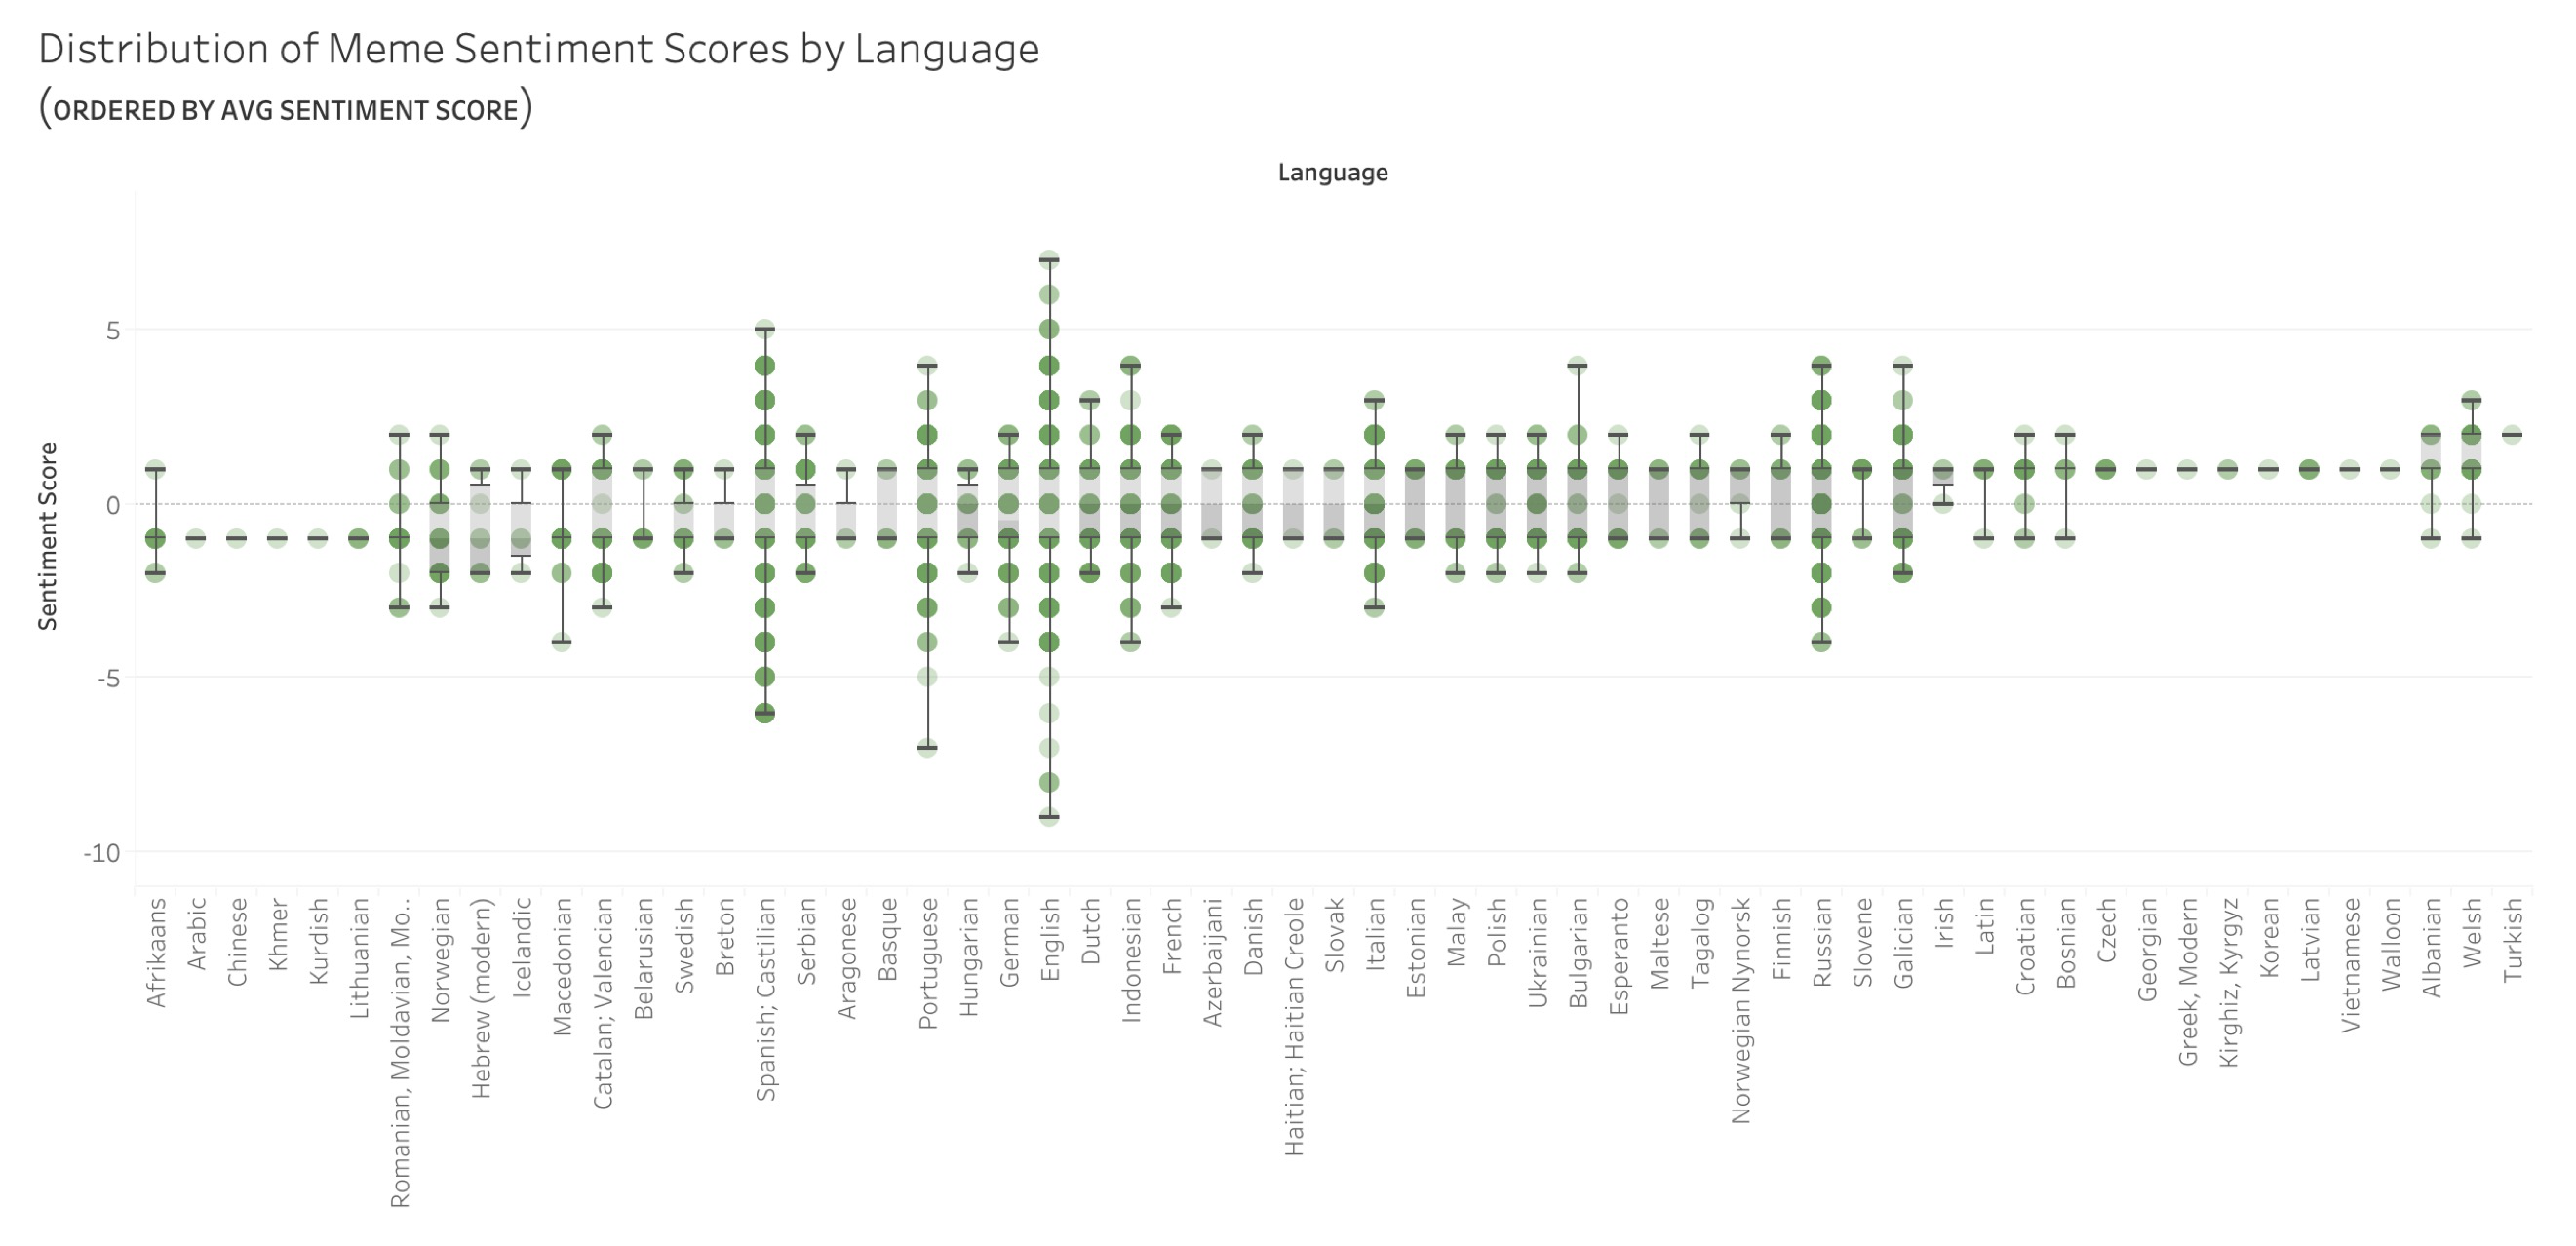

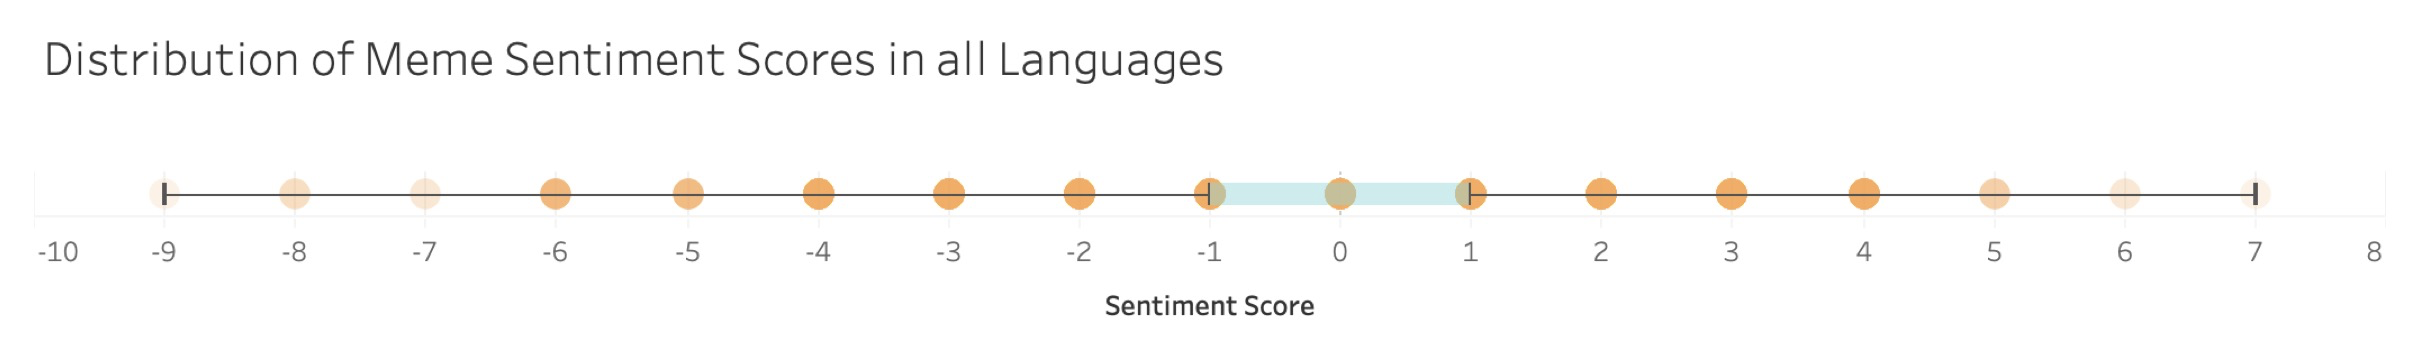

Lower Hinge: -1, Median: -1, Upper Hinge: 1

# Challenge #

**Processing Multiple Directories and Using Filenames as Data :**

Our language lexicon dataset contained 164 .txt files representing 82 languages separated into positive and negative word lists. The language and sentiment information was only contained in the filename ((language)_word_(sentiment).txt), and the content inside the files was not specified using any headers. In order to be efficient, we needed to find a way to automatically process all of our lexicon files – adding a header to each file denoting the nature of the data they container and also pulling the data from the filename to specify the language and sentiment of each word we imported. Using the *Path* and *Re* Python packages, we were able to create a set of commands to process (loop through) all of the files of with the same extension in a single directory: Path().glob{), add a header to each, and then pull out the language and sentiment information in each filename by matching groups with a regular expression. It was an interesting learning process that allowed us to better understand loops, regular expressions, and the procedural intricacies necessary for working with large collections of files storing and carrying data in multiple ways.


**Identifying Languages :**

When processing our memes - breaking them down into basememes, memes, captions, and eventuallyw words, we started off by testing the words in each caption/meme against all 82 lexicons to assign a words_in_language_id, but soon realized there were lots of cognates between lexicons. Basic english ("a"), spanish ("las" and "los"), and french ("un") articles were included in other lexicons. The english verb "is" was also a negative word in separate lexicon. This resulted in the misidentification of numerous caption languages and sentiments. Using this process, memes were often assigned multiple (often more than two) different languages, which also complicated our ability to analyze the data. Multilingual memes are certainly a reality, but we believe this original method overidentified and innacurately represented that phenomenon. Alex suggested that we use a Python package to first probabilistically identify the language of our captions and then attempt to match its words with those in their identified languages' lexicons. First, we tried the *langdetect* package, but it misidentified too many languages in a test sample we gave it. Then we turned to the *langid* package, which gave us much more (but certainly not perfect) accuracy. Ultimately, it allowed us to get around the fact that these lexicons were not meant to identify languages per se, but to analyze datasets of known languages.



# Analysis Tool #

For the analysis of our data, we used *Tableau*, which was completely new to us. To learn how to use Tableau we turned first to the "Tableau Essentials" course on LinkedInLearning (subscription provided by UT) which taught us the basics of importing data, navigating the interface, and creating visualizations. We knew specifically we wanted to generate a box plot of our sentiment scores by language, so we searched the LinkedIn Learning courses for a video on Tableau box plots and found the video "Box plots for multiple dimensions" inside of the "Data Visualization Tips and Tricks" course which taught us how to create the appropriate visualization. 